In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


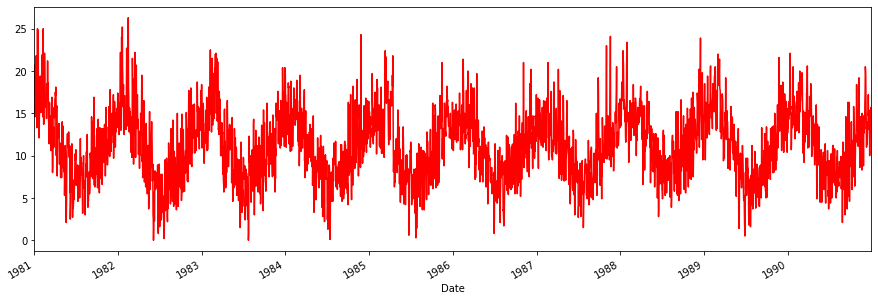

In [4]:
 df.Temp.plot(figsize=(15,5), color="r")

# Dataset Splitting

In [5]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset & Dataloader

In [6]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [7]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)


(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur & Config

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [16]:
config = set_config({
    "input_size" : train_set.n_feature,
    "seq_len" : train_set.n_seq,
    "output_size" : 1, 
    "hidden_size" : 128, 
    "num_layers"  : 3,
    "dropout"     : 0
})

# Training Preparation -> MCOC

In [17]:
model = LSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/lstm")

# Training

In [18]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 134.8645 | Test_cost  = 125.6109 | 




Epoch     2
Train_cost  = 96.2754 | Test_cost  = 73.7993 | 




Epoch     3
Train_cost  = 56.5602 | Test_cost  = 47.5749 | 




Epoch     4
Train_cost  = 38.1785 | Test_cost  = 35.1002 | 




Epoch     5
Train_cost  = 28.9857 | Test_cost  = 27.7601 | 




Epoch     6
Train_cost  = 23.5785 | Test_cost  = 23.2638 | 




Epoch     7
Train_cost  = 20.4472 | Test_cost  = 20.6435 | 




Epoch     8
Train_cost  = 18.7781 | Test_cost  = 19.2291 | 




Epoch     9
Train_cost  = 17.9740 | Test_cost  = 18.5107 | 




Epoch    10
Train_cost  = 17.6053 | Test_cost  = 18.1471 | 




Epoch    11
Train_cost  = 17.4172 | Test_cost  = 17.9513 | 




Epoch    12
Train_cost  = 17.2936 | Test_cost  = 17.8389 | 




Epoch    13
Train_cost  = 17.1981 | Test_cost  = 17.7744 | 




Epoch    14
Train_cost  = 17.1237 | Test_cost  = 17.7394 | 




Epoch    15
Train_cost  = 17.0684 | Test_cost  = 17.7196 | 




Epoch    16
Train_cost  = 17.0280 | Test_cost  = 17.7044 | 




Epoch    17
Train_cost  = 16.9971 | Test_cost  = 17.6875 | 




Epoch    18
Train_cost  = 16.9716 | Test_cost  = 17.6672 | 




Epoch    19
Train_cost  = 16.9493 | Test_cost  = 17.6449 | 




Epoch    20
Train_cost  = 16.9293 | Test_cost  = 17.6228 | 


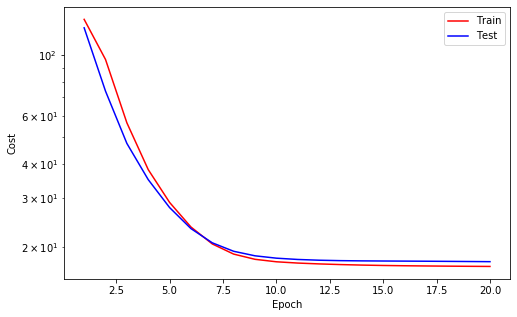



Epoch    21
Train_cost  = 16.9113 | Test_cost  = 17.6022 | 




Epoch    22
Train_cost  = 16.8950 | Test_cost  = 17.5836 | 




Epoch    23
Train_cost  = 16.8803 | Test_cost  = 17.5673 | 




Epoch    24
Train_cost  = 16.8670 | Test_cost  = 17.5531 | 




Epoch    25
Train_cost  = 16.8548 | Test_cost  = 17.5405 | 




Epoch    26
Train_cost  = 16.8437 | Test_cost  = 17.5293 | 




Epoch    27
Train_cost  = 16.8333 | Test_cost  = 17.5190 | 




Epoch    28
Train_cost  = 16.8237 | Test_cost  = 17.5094 | 




Epoch    29
Train_cost  = 16.8147 | Test_cost  = 17.5003 | 




Epoch    30
Train_cost  = 16.8061 | Test_cost  = 17.4917 | 




Epoch    31
Train_cost  = 16.7979 | Test_cost  = 17.4834 | 




Epoch    32
Train_cost  = 16.7902 | Test_cost  = 17.4755 | 




Epoch    33
Train_cost  = 16.7827 | Test_cost  = 17.4680 | 




Epoch    34
Train_cost  = 16.7756 | Test_cost  = 17.4607 | 




Epoch    35
Train_cost  = 16.7687 | Test_cost  = 17.4538 | 




Epoch    36
Train_cost  = 16.7620 | Test_cost  = 17.4472 | 




Epoch    37
Train_cost  = 16.7556 | Test_cost  = 17.4408 | 




Epoch    38
Train_cost  = 16.7493 | Test_cost  = 17.4347 | 




Epoch    39
Train_cost  = 16.7432 | Test_cost  = 17.4287 | 




Epoch    40
Train_cost  = 16.7372 | Test_cost  = 17.4230 | 


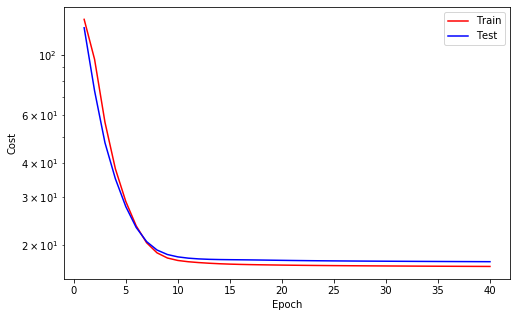



Epoch    41
Train_cost  = 16.7314 | Test_cost  = 17.4174 | 




Epoch    42
Train_cost  = 16.7256 | Test_cost  = 17.4119 | 




Epoch    43
Train_cost  = 16.7199 | Test_cost  = 17.4066 | 




Epoch    44
Train_cost  = 16.7144 | Test_cost  = 17.4014 | 




Epoch    45
Train_cost  = 16.7089 | Test_cost  = 17.3964 | 




Epoch    46
Train_cost  = 16.7034 | Test_cost  = 17.3914 | 




Epoch    47
Train_cost  = 16.6980 | Test_cost  = 17.3866 | 




Epoch    48
Train_cost  = 16.6926 | Test_cost  = 17.3818 | 




Epoch    49
Train_cost  = 16.6873 | Test_cost  = 17.3772 | 




Epoch    50
Train_cost  = 16.6820 | Test_cost  = 17.3728 | 




Epoch    51
Train_cost  = 16.6767 | Test_cost  = 17.3686 | 




Epoch    52
Train_cost  = 16.6715 | Test_cost  = 17.3646 | 




Epoch    53
Train_cost  = 16.6661 | Test_cost  = 17.3611 | 




Epoch    54
Train_cost  = 16.6601 | Test_cost  = 17.3575 | 




Epoch    55
Train_cost  = 16.6537 | Test_cost  = 17.3522 | 




Epoch    56
Train_cost  = 16.6475 | Test_cost  = 17.3453 | 




Epoch    57
Train_cost  = 16.6416 | Test_cost  = 17.3384 | 




Epoch    58
Train_cost  = 16.6358 | Test_cost  = 17.3326 | 




Epoch    59
Train_cost  = 16.6302 | Test_cost  = 17.3280 | 




Epoch    60
Train_cost  = 16.6248 | Test_cost  = 17.3242 | 


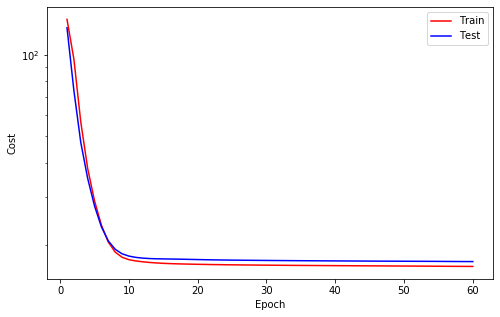



Epoch    61
Train_cost  = 16.6194 | Test_cost  = 17.3208 | 




Epoch    62
Train_cost  = 16.6141 | Test_cost  = 17.3175 | 




Epoch    63
Train_cost  = 16.6088 | Test_cost  = 17.3139 | 




Epoch    64
Train_cost  = 16.6034 | Test_cost  = 17.3103 | 




Epoch    65
Train_cost  = 16.5980 | Test_cost  = 17.3066 | 




Epoch    66
Train_cost  = 16.5925 | Test_cost  = 17.3029 | 




Epoch    67
Train_cost  = 16.5870 | Test_cost  = 17.2993 | 




Epoch    68
Train_cost  = 16.5815 | Test_cost  = 17.2959 | 




Epoch    69
Train_cost  = 16.5760 | Test_cost  = 17.2925 | 




Epoch    70
Train_cost  = 16.5704 | Test_cost  = 17.2892 | 




Epoch    71
Train_cost  = 16.5648 | Test_cost  = 17.2860 | 




Epoch    72
Train_cost  = 16.5592 | Test_cost  = 17.2828 | 




Epoch    73
Train_cost  = 16.5536 | Test_cost  = 17.2799 | 




Epoch    74
Train_cost  = 16.5479 | Test_cost  = 17.2771 | 




Epoch    75
Train_cost  = 16.5422 | Test_cost  = 17.2746 | 




Epoch    76
Train_cost  = 16.5362 | Test_cost  = 17.2722 | 




Epoch    77
Train_cost  = 16.5298 | Test_cost  = 17.2688 | 




Epoch    78
Train_cost  = 16.5236 | Test_cost  = 17.2646 | 




Epoch    79
Train_cost  = 16.5174 | Test_cost  = 17.2609 | 




Epoch    80
Train_cost  = 16.5110 | Test_cost  = 17.2583 | 


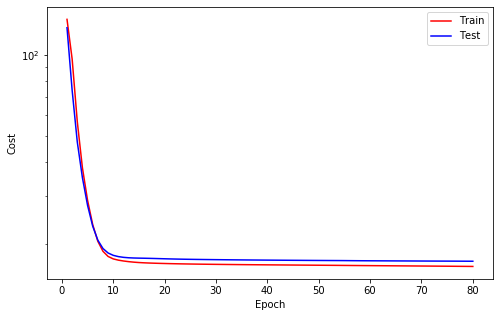



Epoch    81
Train_cost  = 16.5041 | Test_cost  = 17.2551 | 




Epoch    82
Train_cost  = 16.4974 | Test_cost  = 17.2510 | 




Epoch    83
Train_cost  = 16.4908 | Test_cost  = 17.2471 | 




Epoch    84
Train_cost  = 16.4843 | Test_cost  = 17.2440 | 




Epoch    85
Train_cost  = 16.4778 | Test_cost  = 17.2416 | 




Epoch    86
Train_cost  = 16.4713 | Test_cost  = 17.2398 | 




Epoch    87
Train_cost  = 16.4647 | Test_cost  = 17.2384 | 




Epoch    88
Train_cost  = 16.4580 | Test_cost  = 17.2370 | 




Epoch    89
Train_cost  = 16.4512 | Test_cost  = 17.2357 | 




Epoch    90
Train_cost  = 16.4442 | Test_cost  = 17.2350 | 




Epoch    91
Train_cost  = 16.4364 | Test_cost  = 17.2350 | 
==> EarlyStop patience =  1 | Best test_cost: 17.2350




Epoch    92
Train_cost  = 16.4272 | Test_cost  = 17.2337 | 




Epoch    93
Train_cost  = 16.4167 | Test_cost  = 17.2287 | 




Epoch    94
Train_cost  = 16.4052 | Test_cost  = 17.2217 | 




Epoch    95
Train_cost  = 16.3917 | Test_cost  = 17.2156 | 




Epoch    96
Train_cost  = 16.3734 | Test_cost  = 17.2126 | 




Epoch    97
Train_cost  = 16.3148 | Test_cost  = 17.2172 | 
==> EarlyStop patience =  1 | Best test_cost: 17.2126




Epoch    98
Train_cost  = 16.5699 | Test_cost  = 15.6578 | 




Epoch    99
Train_cost  = 15.0916 | Test_cost  = 15.2248 | 




Epoch   100
Train_cost  = 14.2384 | Test_cost  = 12.7922 | 


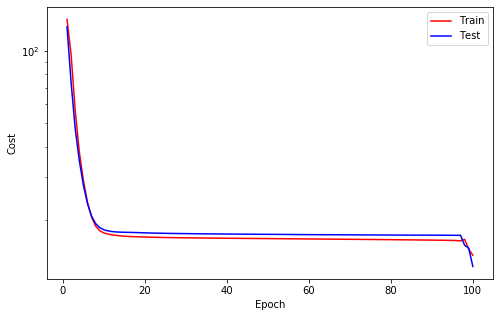



Epoch   101
Train_cost  = 12.4942 | Test_cost  = 11.6201 | 




Epoch   102
Train_cost  = 11.2512 | Test_cost  = 10.1047 | 




Epoch   103
Train_cost  = 10.0469 | Test_cost  = 9.0878 | 




Epoch   104
Train_cost  = 9.1607 | Test_cost  = 8.3012 | 




Epoch   105
Train_cost  = 8.4366 | Test_cost  = 7.3699 | 




Epoch   106
Train_cost  = 7.9145 | Test_cost  = 7.0015 | 




Epoch   107
Train_cost  = 7.5791 | Test_cost  = 6.6724 | 




Epoch   108
Train_cost  = 7.3005 | Test_cost  = 6.4435 | 




Epoch   109
Train_cost  = 7.1195 | Test_cost  = 6.2841 | 




Epoch   110
Train_cost  = 6.9932 | Test_cost  = 6.1215 | 




Epoch   111
Train_cost  = 6.8761 | Test_cost  = 6.0547 | 




Epoch   112
Train_cost  = 6.8089 | Test_cost  = 5.9782 | 




Epoch   113
Train_cost  = 6.7496 | Test_cost  = 5.8761 | 




Epoch   114
Train_cost  = 6.6718 | Test_cost  = 5.8273 | 




Epoch   115
Train_cost  = 6.6435 | Test_cost  = 5.7793 | 




Epoch   116
Train_cost  = 6.5866 | Test_cost  = 5.7485 | 




Epoch   117
Train_cost  = 6.5705 | Test_cost  = 5.6786 | 




Epoch   118
Train_cost  = 6.5565 | Test_cost  = 5.6890 | 
==> EarlyStop patience =  1 | Best test_cost: 5.6786




Epoch   119
Train_cost  = 6.5410 | Test_cost  = 5.6343 | 




Epoch   120
Train_cost  = 6.5417 | Test_cost  = 5.5853 | 


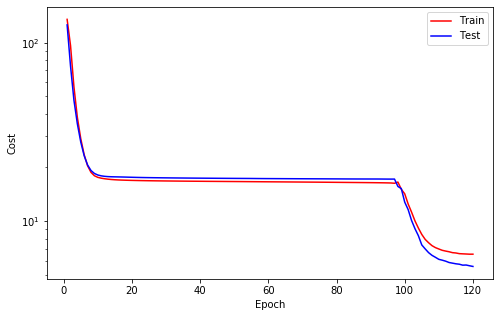



Epoch   121
Train_cost  = 6.5144 | Test_cost  = 5.5067 | 




Epoch   122
Train_cost  = 6.4786 | Test_cost  = 5.4327 | 




Epoch   123
Train_cost  = 6.4549 | Test_cost  = 5.3969 | 




Epoch   124
Train_cost  = 6.4306 | Test_cost  = 5.4591 | 
==> EarlyStop patience =  1 | Best test_cost: 5.3969




Epoch   125
Train_cost  = 6.3892 | Test_cost  = 5.4681 | 
==> EarlyStop patience =  2 | Best test_cost: 5.3969




Epoch   126
Train_cost  = 6.3392 | Test_cost  = 5.4706 | 
==> EarlyStop patience =  3 | Best test_cost: 5.3969




Epoch   127
Train_cost  = 6.2932 | Test_cost  = 5.3956 | 




Epoch   128
Train_cost  = 6.2315 | Test_cost  = 5.3194 | 




Epoch   129
Train_cost  = 6.1890 | Test_cost  = 5.2929 | 




Epoch   130
Train_cost  = 6.1708 | Test_cost  = 5.2845 | 




Epoch   131
Train_cost  = 6.1524 | Test_cost  = 5.2690 | 




Epoch   132
Train_cost  = 6.1407 | Test_cost  = 5.2567 | 




Epoch   133
Train_cost  = 6.1437 | Test_cost  = 5.2460 | 




Epoch   134
Train_cost  = 6.1300 | Test_cost  = 5.2369 | 




Epoch   135
Train_cost  = 6.1172 | Test_cost  = 5.2325 | 




Epoch   136
Train_cost  = 6.1125 | Test_cost  = 5.2364 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2325




Epoch   137
Train_cost  = 6.1235 | Test_cost  = 5.2414 | 
==> EarlyStop patience =  2 | Best test_cost: 5.2325




Epoch   138
Train_cost  = 6.0960 | Test_cost  = 5.2743 | 
==> EarlyStop patience =  3 | Best test_cost: 5.2325




Epoch   139
Train_cost  = 6.1113 | Test_cost  = 5.3074 | 
==> EarlyStop patience =  4 | Best test_cost: 5.2325




Epoch   140
Train_cost  = 6.0828 | Test_cost  = 5.3143 | 


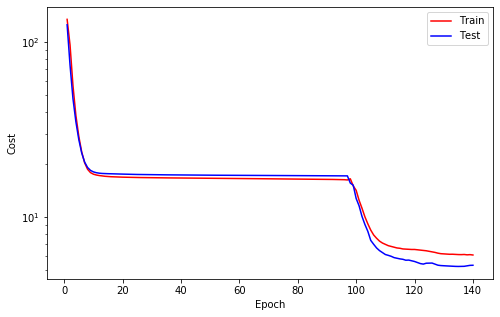

==> EarlyStop patience =  5 | Best test_cost: 5.2325
==> Execute Early Stopping at epoch: 140 | Best test_cost: 5.2325
==> Best model is saved at model/lstm


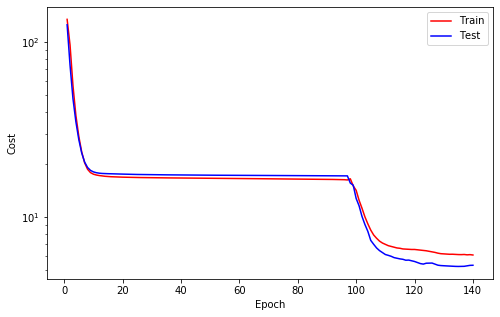

In [19]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [20]:
from luwiji.rnn import illustration

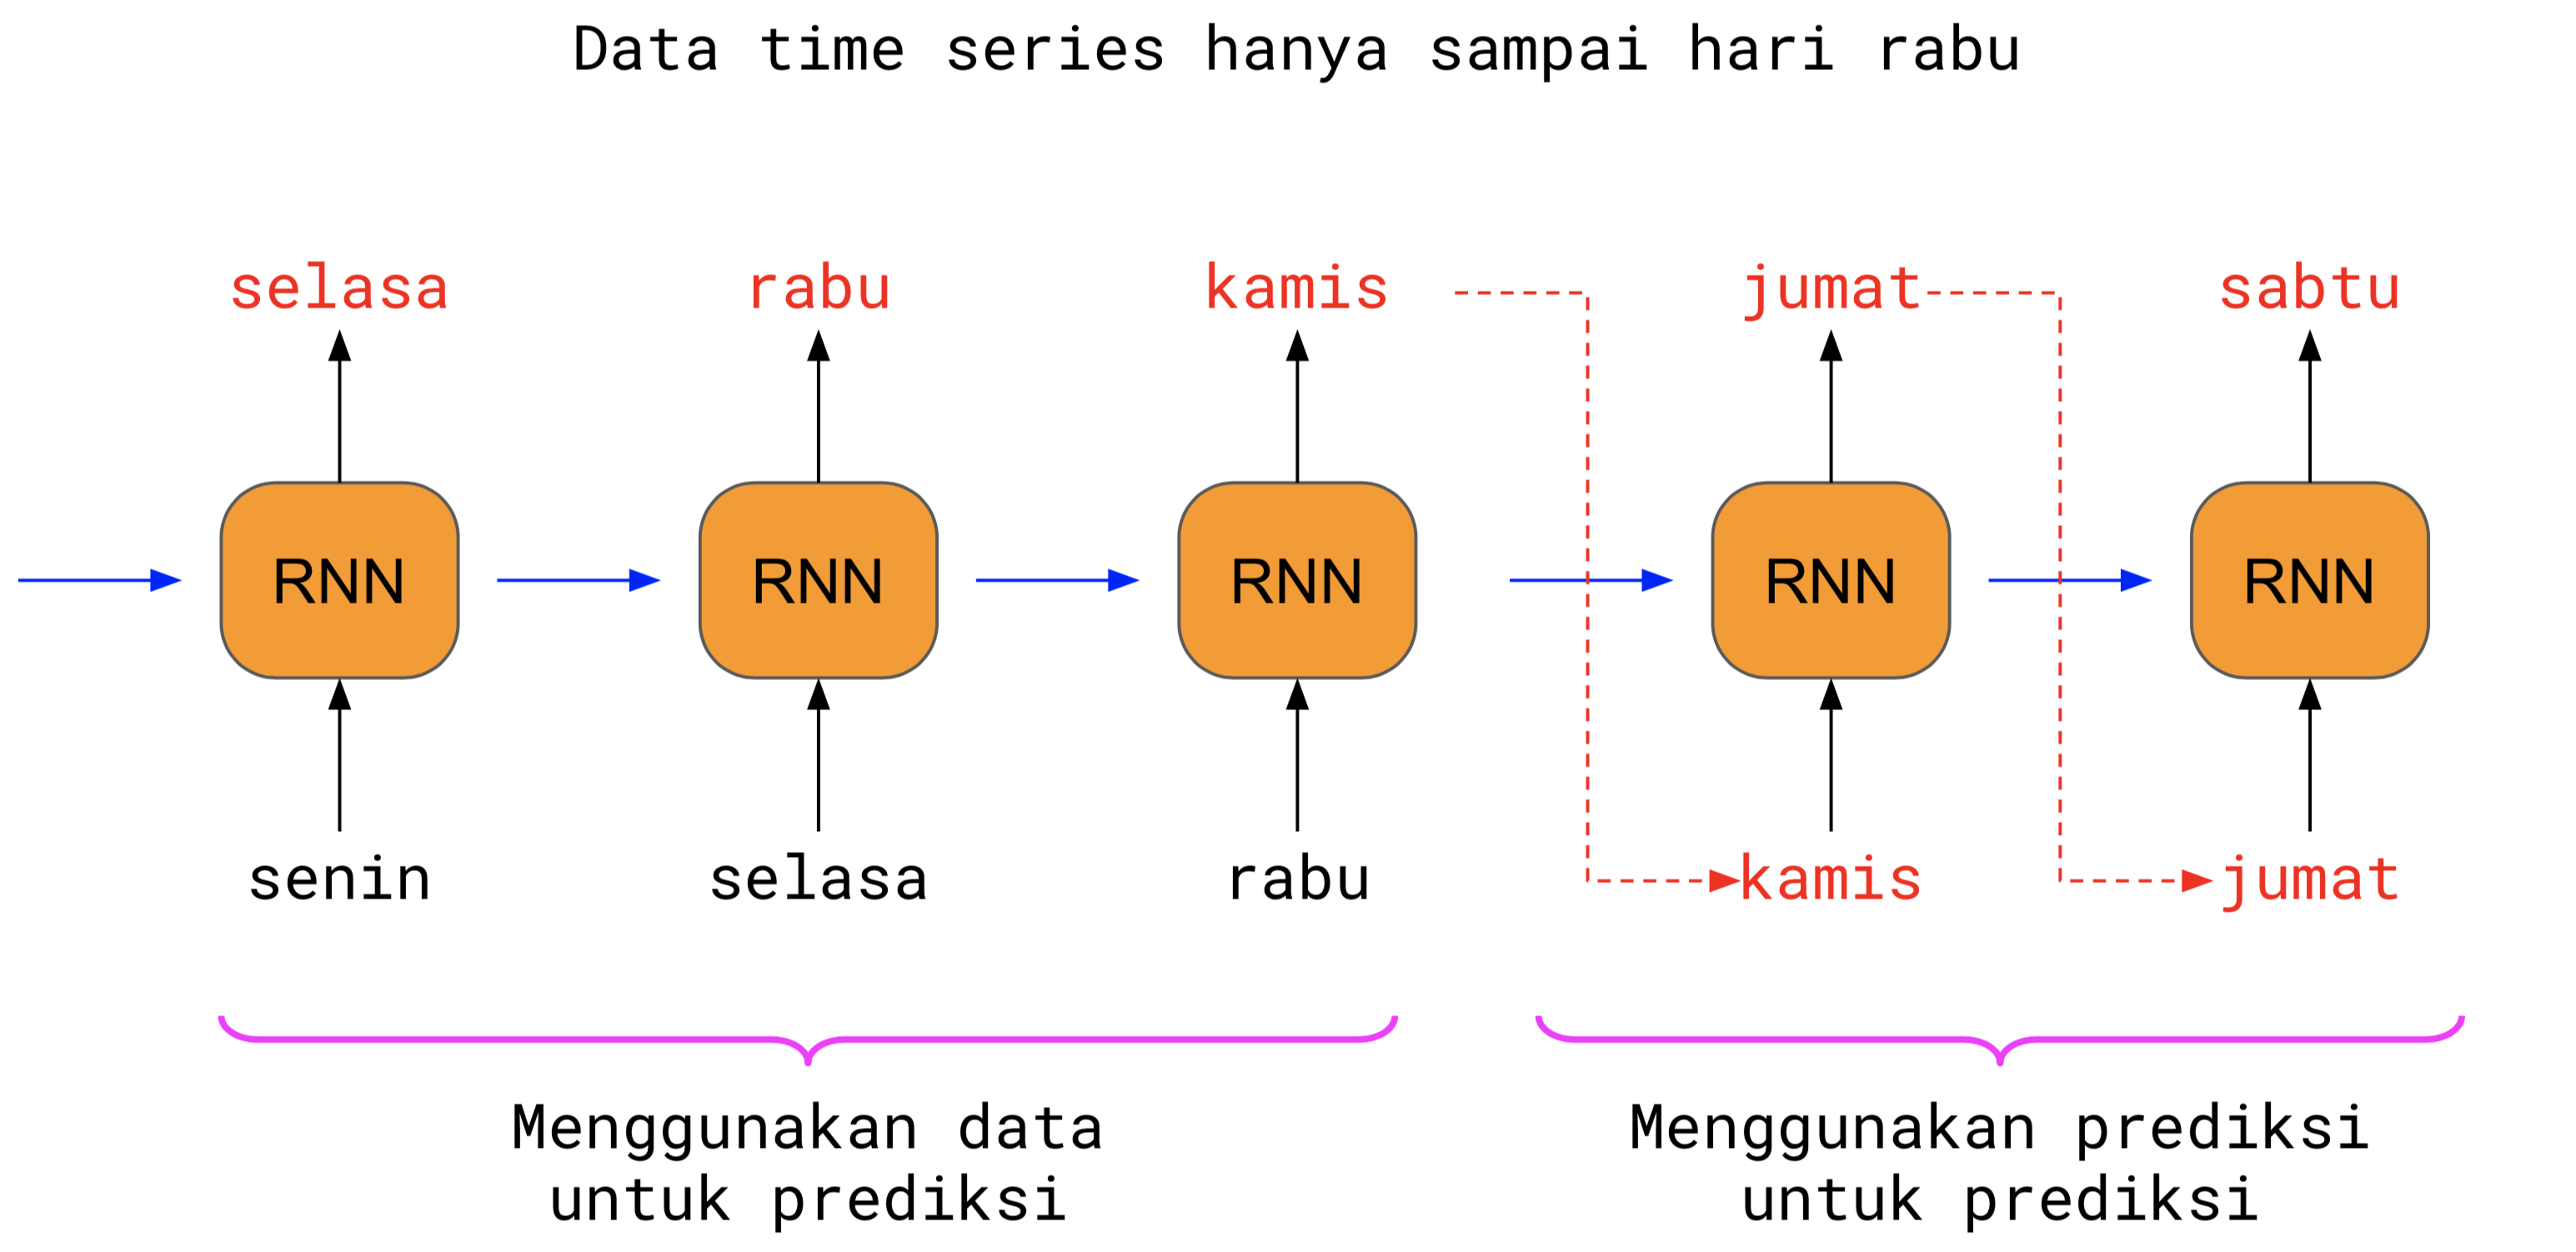

In [21]:
illustration.forecast

In [22]:
from utils import data4pred, pred4pred

In [23]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

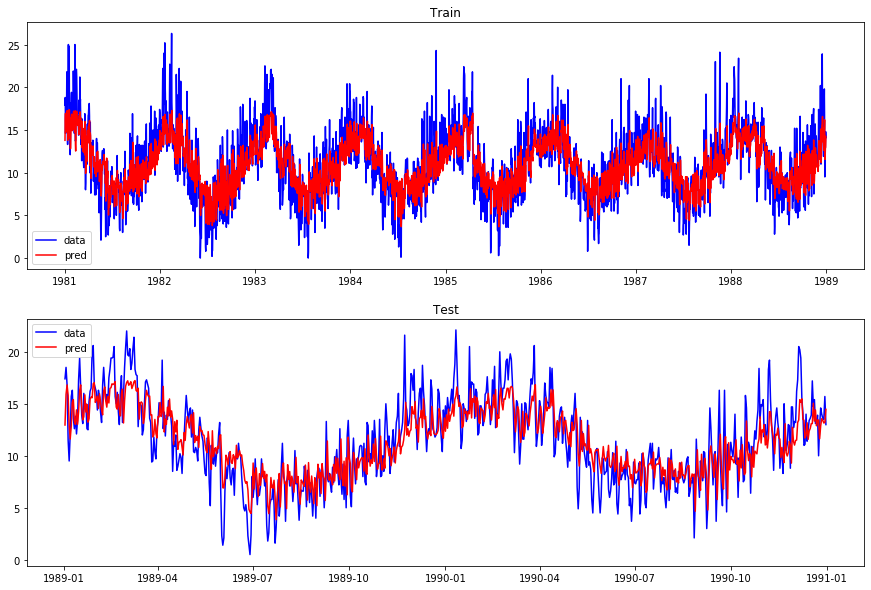

In [24]:
# Data 4 Pred
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

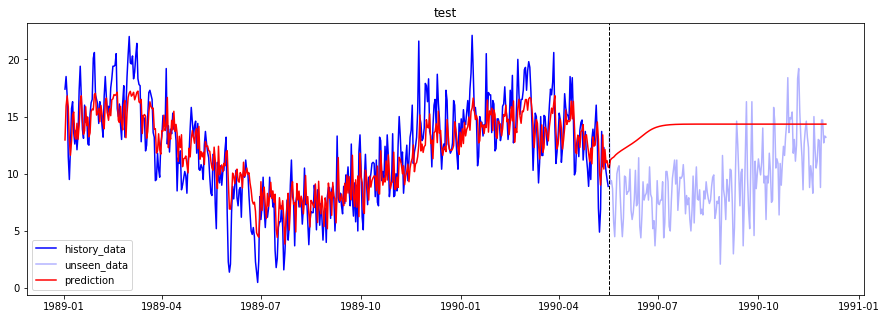

In [25]:
# Pred 4 Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")